Creation du DATASET

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Définir les chemins des dossiers
base_path = "Landscapes_images"
categories = ["BUILDING", "FOREST", "MOUTAIN", "ROAD", "SEA"]

# Charger les images et les labels
X = []
y = []

for category in categories:
    folder_path = os.path.join(base_path, category)
    label = categories.index(category)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        # Redimensionner l'image à la taille souhaitée (256*256)
        img = cv2.resize(img, (256, 256))

        X.append(img)
        y.append(label)

# Convertir les listes en tableaux numpy
X = np.array(X)
y = np.array(y)

# Normaliser les valeurs des pixels à la plage [0, 1]
X = X / 255.0

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir les labels en one-hot encoding
y_train = to_categorical(y_train, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))
# Afficher la forme des ensembles d'entraînement et de test
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

save_path = "./Landscapes_images/sauvegarde/"

np.save(os.path.join(save_path, "X_train.npy"), X_train)
np.save(os.path.join(save_path, "y_train.npy"), y_train)
np.save(os.path.join(save_path, "X_test.npy"), X_test)
np.save(os.path.join(save_path, "y_test.npy"), y_test)

with open(os.path.join(save_path, "categories.txt"), "w") as file:
    for category in categories:
        file.write(category + "\n")




Shape of X_train: (1303, 256, 256, 3)
Shape of y_train: (1303, 5)
Shape of X_test: (326, 256, 256, 3)
Shape of y_test: (326, 5)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Charger les données
X_train = np.load("./Landscapes_images/sauvegarde/X_train.npy")
y_train = np.load("./Landscapes_images/sauvegarde/y_train.npy")
X_test = np.load("./Landscapes_images/sauvegarde/X_test.npy")
y_test = np.load("./Landscapes_images/sauvegarde/y_test.npy")

# Créer le modèle
model = models.Sequential()

# Ajouter des couches au modèle
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(categories), activation='softmax'))


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Pout utiliser cette fonction de loss, il faut que les labels soit des entiers

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', # en one hot -> les labels sont des vecteurs avec des zeros sauf des 1 là où la classe appartient
              metrics=['accuracy'])

# Afficher la structure du modèle
model.summary()

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Évaluer le modèle sur l'ensemble de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy on test set: {test_acc}")





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)           

1/1 [==============================] - 0s 45ms/step


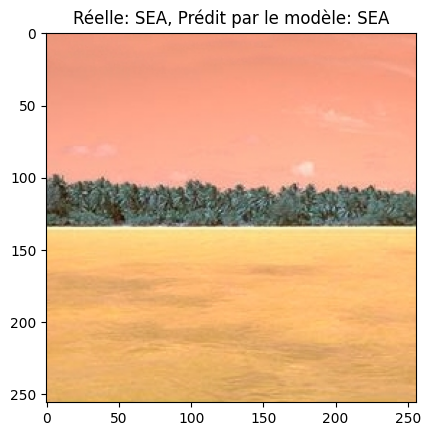

In [16]:
import random
import matplotlib.pyplot as plt

# Liste des catégories correspondant aux classes
categories = ["BUILDING", "FOREST", "MOUNTAIN", "ROAD", "SEA"]

# Choisir une image au hasard dans X_test
index = random.randint(0, len(X_test) - 1)
random_image = X_test[index]
random_label = y_test[index]

# Ajouter une dimension supplémentaire pour la prédiction
random_image = np.expand_dims(random_image, axis=0)

# Faire la prédiction avec le modèle
predictions = model.predict(random_image)

# Convertir les probabilités en classe prédite
predicted_class = np.argmax(predictions)

# Afficher l'image
plt.imshow(random_image[0])
plt.title(f"Réelle: {categories[np.argmax(random_label)]}, Prédit par le modèle: {categories[predicted_class]}")
plt.show()
